In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [85]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120 
mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']}) ## for Palatino and other serif fonts use: #rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
# from cycler import cycler
# # mpl.rcParams['axes.prop_cycle'] = cycler(color='rkgbcmy')
# mpl.rcParams['axes.prop_cycle'] = cycler(color=['tab:red', 'k', 'tab:green', 'tab:blue', 'tab:grey'])
# mpl.rcParams.update({'figure.autolayout': True})
# mpl.rcParams.update({'font.size': 12})
# mpl.rcParams.update({'legend.fontsize': 11})
# mpl.rcParams.update({'axes.xmargin': 0})
# mpl.rcParams.update({'lines.solid_capstyle': 'round'})
# mpl.rcParams.update({'lines.solid_joinstyle': 'round'})
# mpl.rcParams.update({'lines.dash_capstyle': 'round'})
# mpl.rcParams.update({'lines.dash_joinstyle': 'round'})
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
import sys
sys.path.append('../')

In [4]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_alg import get_sample_eta_w,propagate_model
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input,plot_comparison,plot_one_funnel
from trajopt import trajopt
from Scaling import TrajectoryScaling
import cvxpy as cvx
from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.linalg import sqrtm

(CVXPY) Jan 19 03:49:01 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <F9700F1C-290B-3DF3-8D09-CFDF44BAE051> /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


In [5]:
N = 20
tf = 10
delT = tf/N

## obstacle setting

In [6]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c_list.append([-1,2])
H_list.append(get_H_obs(4,2))
c_list.append([5,6])
H_list.append(get_H_obs(4,2))
# c_list.append([0,2])
# H_list.append(get_H_obs(0.5,0.5))
# c_list.append([2,2])
# H_list.append(get_H_obs(0.5,0.5))
# c_list.append([1,4])
# H_list.append(get_H_obs(0.5,0.5))
# c_list.append([3,4])
# H_list.append(get_H_obs(0.5,0.5))
# c_list.append([2,6])
# H_list.append(get_H_obs(0.5,0.5))

## initial and final conditions 

In [7]:
myModel = UnicycleModel.unicycle3('unicycle','analytic')

ix = myModel.ix
iu = myModel.iu
iw = myModel.iw
iq = myModel.iq
iphi = myModel.ip

Co = myModel.C
Do = myModel.D
Eo = myModel.E
Go = myModel.G

myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)

In [8]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = np.deg2rad(0)

xf = np.zeros(3)
xf[0] = 4.0
xf[1] = 8.0
xf[2] = np.deg2rad(0)

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

In [9]:
x_max = np.array([10,10,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5])
u_min = np.zeros(iu)

traj_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

In [10]:
traj_solver= trajopt('unicycle',N,tf,50,myModel,myCost,myConst,Scaling=traj_scaling,
    type_discretization="foh",
    w_c=1e1,w_vc=1e2,w_tr=4*1e0,tol_vc=1e-6,tol_tr=1e-6,tol_dyn=1e-6,verbosity=True)

Is DPP?  True


In [11]:
_,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf)
tnom = np.array(range(N+1))*delT

┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │1173.219   │10.000    │16.9     │0          │-1.17e+03   │0(1.00  )│0(-0.021)│0(1.398 )│
│2     │859.483    │10.000    │22.9     │0          │314         │0(0.79  )│0(0.349 )│0(1.397 )│
│3     │719.698    │10.000    │33.2     │0          │140         │0(0.58  )│0(0.100 )│0(1.059 )│
│4     │263.287    │10.000    │25.6     │0          │456         │1(-10.16)│0(0.247 )│0(0.471 )│
│5     │431.886    │10.0

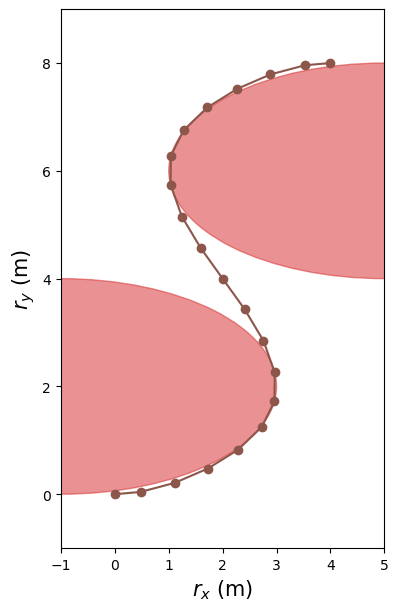

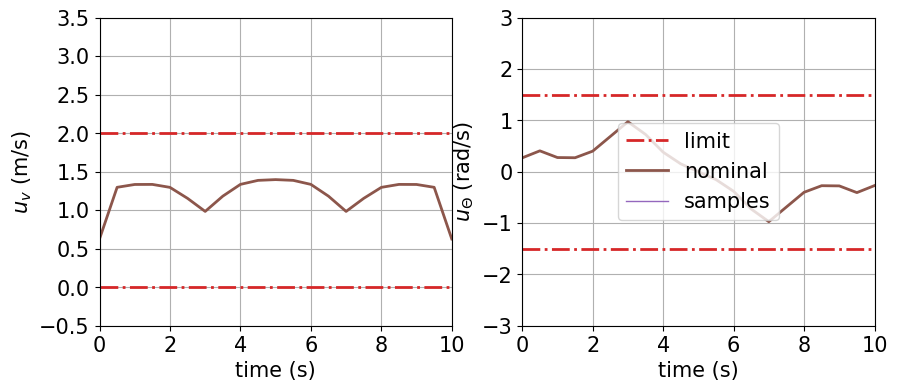

In [12]:
fS = 15
plt.figure(0,figsize=(15,7))
ax = plt.gca()
for ce,H in zip(c_list,H_list) :
    rx = 1/H[0,0]
    ry = 1/H[1,1]
    circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=0.5,fill=True)
    ax.add_patch(circle1)
plt.plot(xnom[:,0],xnom[:,1],'o-',color='tab:brown',label='traj w/o funnel')
# plot_traj_set(x0,u0,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([-1.0, 5.0, -1.0, 9.0])
plt.xlabel('$r_x$ (m)', fontsize = fS)
plt.ylabel('$r_y$ (m)', fontsize = fS)


plt.figure(1,figsize=(10,4))
plt.subplot(121)
plt.plot(tnom, unom[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tnom, unom[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tnom, unom[:,0],'-',color='tab:brown',alpha=1.0,linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)

plt.subplot(122)
plt.plot(tnom, unom[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tnom, unom[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tnom, unom[:,1],'-',color='tab:brown',alpha=1.0,linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
# plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)

In [13]:
ufoh = interpolate.interp1d(tnom,unom,axis=0)
def dfdt(t,V) :
    u = ufoh(t)
    x = V[idx_x]
    dxdt = myModel.forward(x,u).squeeze()
    return dxdt
# tfwd = np.linspace(0,tf,N_fwd)
# sol = solve_ivp(dfdt,(0,tf),xi,t_eval=tfwd,method='RK45',rtol=1e-6,atol=1e-10)
# xfwd = sol.y.T
# ufwd = ufoh(tfwd)

# Funnel synthesis

In [14]:
# new obstacles
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
# obstacle
r = 0.4
c_list = []
H_list = []
c_list.append([-1,2])
H_list.append(get_H_obs(3,1))
c_list.append([5,6])
H_list.append(get_H_obs(3.5,1))
# c_list.append([1,0])
# c_list.append([3,0])
# c_list.append([0,2])
# c_list.append([2,2])
# c_list.append([1,4])
# c_list.append([3,4])
# c_list.append([0,6])
# c_list.append([2,6])
# c_list.append([1,8])
# c_list.append([3,8])
# H_list = [get_H_obs(r,r) for i in range(len(c_list))]

In [15]:
# get A,B,F - we already have C,D,E,G
A,B = myModel.diff(xnom,unom)
F = myModel.diff_F(xnom,unom,np.zeros((N+1,iw)))

# Qmax,Rmax
Qmax = []
for i in range(N+1) :
    Qmax.append(np.diag([2**2,2**2,np.deg2rad(30)**2]))  # user-defined parameters
Rmax = myConst.get_Rmax(unom) # computed from the input constraints

# constraint relevant terms
const_input = myConst.get_const_input(xnom,unom)
const_state = myConst.get_const_state(xnom,unom,c_list,H_list)

## Estimation of $\gamma$

In [16]:
from Lipschitz import Lipschitz
lip_estimator = Lipschitz(ix,iu,iq,iphi,iw,N,num_sample=100,flag_uniform=True)
lip_estimator.initialize(xnom,unom,Qmax,Rmax,A,B,Co,Do,Eo,F,Go,myModel)
gamma = lip_estimator.update_lipschitz_norm(myModel)
print(gamma)

[0.23947659 0.34272883 0.350198   0.35033087 0.34218791 0.31450369
 0.32429117 0.3229045  0.35443084 0.36570528 0.36797356 0.36570528
 0.35443084 0.3229045  0.32429117 0.31450369 0.34218791 0.35033087
 0.350198   0.34272883 0.23947659]


## Estimation of $\beta$

In [17]:
Afoh = interpolate.interp1d(tnom,A,axis=0)
Bfoh = interpolate.interp1d(tnom,B,axis=0)
Ffoh = interpolate.interp1d(tnom,F,axis=0)

In [18]:
# TODO - this part can be vectorized
idx_x = slice(0,ix)
beta = []
N_sampling = 20
for i in range(N) :
    t_eval = np.linspace(tnom[i],tnom[i+1],N_sampling)
    sol = solve_ivp(dfdt,(tnom[i],tnom[i+1]),xnom[i],t_eval=t_eval,method='RK45',rtol=1e-6,atol=1e-10)
    x_eval = sol.y[idx_x,:].T
    u_eval = ufoh(t_eval)
    A_eval,B_eval = myModel.diff(x_eval,u_eval)
    F_eval = myModel.diff_F(x_eval,u_eval,np.zeros((N_sampling,iw)))
    eA = Afoh(t_eval) - A_eval
    eB = Bfoh(t_eval) - B_eval
    eF = Ffoh(t_eval) - F_eval
    Delta = np.dstack((eA,eB,eF))
    beta.append(np.max(np.linalg.norm(Delta,axis=(1,2),ord=2)))
beta = np.array(beta)
print(beta)

[0.03689153 0.01036054 0.003142   0.01009252 0.02111382 0.03230463
 0.03386301 0.02459298 0.01784564 0.01320017 0.01320017 0.01784564
 0.02459298 0.03386301 0.03230463 0.02111382 0.01009252 0.003142
 0.01036054 0.03689153]


In [19]:
C = np.vstack((np.eye(ix),np.zeros((iu,ix)),np.zeros((iw,ix)),Co))
D = np.vstack((np.zeros((ix,iu)),np.eye(iu),np.zeros((iw,iu)),Do))
E = np.hstack((np.eye(ix),Eo))
G = np.vstack((np.zeros((ix,iw)),np.zeros((iu,iw)),np.eye(iw),Go))

## Scaling

In [20]:
x_max = np.array([1,1,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

funl_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

In [21]:
from nl_funlopt_by_COP import nl_funlopt_by_COP

In [49]:
funl_solver1 = nl_funlopt_by_COP(ix,iu,iq,iphi,iw,N,delT,
                             funl_scaling,
                             myModel,
                             max_iter=1,type_copositivity=1)

lambda_w = 0.4
funl_solver1.cvx_initialize(lambda_w,Qini=None,Qf=None,Qmax=Qmax,
    const_state=const_state,const_input=const_input)

Is DPP?  True


In [50]:
_,_,_,cost = funl_solver1.run(gamma,beta,A,B,C,D,E,F,G)
print("cost",cost)

optimal
cost -2.6748483906650957


In [51]:
funl_solver1 = nl_funlopt_by_COP(ix,iu,iq,iphi,iw,N,delT,
                             funl_scaling,
                             myModel,
                             max_iter=1,type_copositivity=2)
lambda_w = 0.4
funl_solver1.cvx_initialize(lambda_w,Qini=None,Qf=None,Qmax=Qmax,
    const_state=const_state,const_input=const_input)

Is DPP?  True


In [52]:
Q1,K1,Y1,cost1 = funl_solver1.run(gamma,beta,A,B,C,D,E,F,G)
print("cost",cost1)

optimal
cost -2.6926322302799552


In [53]:
Yfoh = interpolate.interp1d(tnom,Y1,axis=0)
Qfoh = interpolate.interp1d(tnom,Q1,axis=0)
idx_x = slice(0,ix)
N_fwd = 161
tfwd = np.linspace(0,tf,N_fwd)
sol = solve_ivp(dfdt,(0,tf),xi,t_eval=tfwd,method='RK45',rtol=1e-6,atol=1e-10)
xfwd = sol.y[idx_x,:].T
ufwd = ufoh(tfwd)
Qfwd = Qfoh(tfwd)
Qfwd_inv = np.linalg.inv(Qfwd)
Yfwd = Yfoh(tfwd)
Kfwd = Yfwd@Qfwd_inv

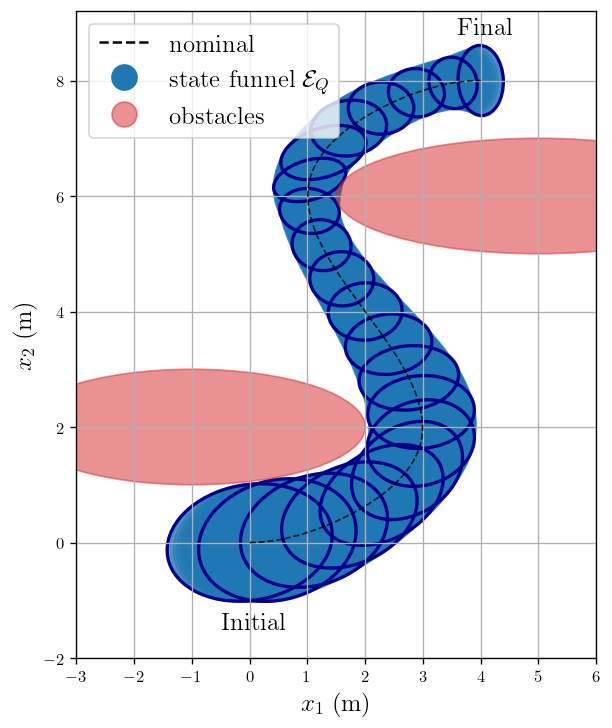

In [92]:
plt.figure(figsize=(7,7))
plt.rcParams["font.family"] = "Times New Roman"
plot_one_funnel(xfwd,Qfwd,xnom,Q1,xi=xnom[0],xf=xnom[-1],Qi=None,Qf=None,plt=plt,fS=fS)
plt.grid(True)
ax = plt.gca()
for ce,H in zip(c_list,H_list) :
    rx = 1/H[0,0]
    ry = 1/H[1,1]
    circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=0.5,fill=True)
    ax.add_patch(circle1)
plt.grid(True)
plt.text(-0.5,-1.5,'Initial',fontsize=fS)
plt.text(3.6,8.8,'Final',fontsize=fS)
# plt.plot(xupper[:,0],xupper[:,1])
plt.savefig('../image/funnel_result.pdf',bbox_inches='tight')

In [55]:
def get_state_margin_by_funnel(Q) :
    N = len(Q) - 1
    a1 = np.array([1,0,0])
    a2 = np.array([0,1,0])
    a3 = np.array([0,0,1])
    xfunl1 = []
    yfunl1 = []
    tfunl1 = []
    for i in range(N+1) :
        xfunl1.append(np.sqrt(a1.T@Q[i]@a1))
        yfunl1.append(np.sqrt(a2.T@Q[i]@a2))
        tfunl1.append(np.sqrt(a3.T@Q[i]@a3))
    xfunl1 = np.array(xfunl1)
    yfunl1 = np.array(yfunl1)
    tfunl1 = np.array(tfunl1)
    return xfunl1,yfunl1,tfunl1
def get_input_margin_by_funnel(Q,K) :
    N = len(Q) - 1
    R1 = []
    for i in range(N+1) :
        R1.append(K[i]@Q[i]@K[i].T)
    a1 = np.array([1,0])
    a2 = np.array([0,1])
    vfunl1 = []
    wfunl1 = []
    for i in range(N+1) :
        vfunl1.append(np.sqrt(a1.T@R1[i]@a1))
        wfunl1.append(np.sqrt(a2.T@R1[i]@a2))
    vfunl1 = np.array(vfunl1)
    wfunl1 = np.array(wfunl1)
    return vfunl1,wfunl1

In [56]:
xfunl1,yfunl1,thfunl1 = get_state_margin_by_funnel(Qfwd)
vfunl1,wfunl1 = get_input_margin_by_funnel(Qfwd,Kfwd)
vfunl1_n,wfunl1_n = get_input_margin_by_funnel(Q1,K1)

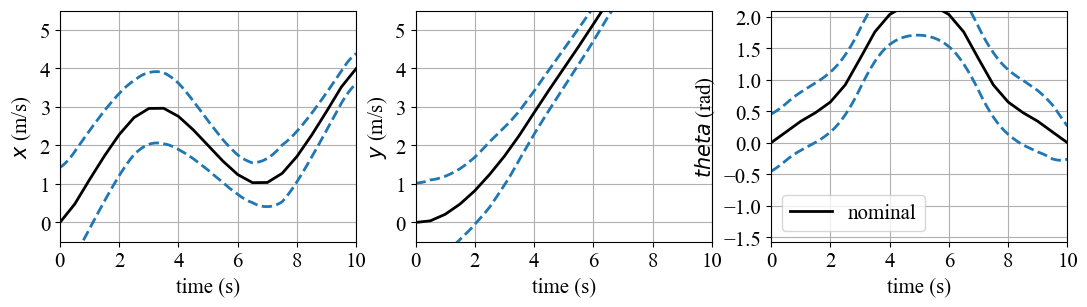

In [57]:
plt.figure(1,figsize=(13,3))
plt.subplot(131)
plt.plot(tnom, xnom[:,0],'-',color='black',alpha=1.0,linewidth=2.0,label='nominal')

plt.plot(tfwd, xfwd[:,0]+xfunl1,'--',color='tab:blue',alpha=1.0,linewidth=2.0)
plt.plot(tfwd, xfwd[:,0]-xfunl1,'--',color='tab:blue',alpha=1.0,linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$x$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 5.5])
plt.grid(True)

plt.subplot(132)
plt.plot(tnom, xnom[:,1],'-',color='black',alpha=1.0,linewidth=2.0,label='nominal')

plt.plot(tfwd, xfwd[:,1]+yfunl1,'--',color='tab:blue',alpha=1.0,linewidth=2.0)
plt.plot(tfwd, xfwd[:,1]-yfunl1,'--',color='tab:blue',alpha=1.0,linewidth=2.0)

plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$y$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 5.5])
plt.grid(True)

plt.subplot(133)
plt.plot(tnom, xnom[:,2],'-',color='black',alpha=1.0,linewidth=2.0,label='nominal')

plt.plot(tfwd, xfwd[:,2]+thfunl1,'--',color='tab:blue',alpha=1.0,linewidth=2.0)
plt.plot(tfwd, xfwd[:,2]-thfunl1,'--',color='tab:blue',alpha=1.0,linewidth=2.0)

plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$theta$ (rad)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -np.deg2rad(90), np.deg2rad(120)])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)


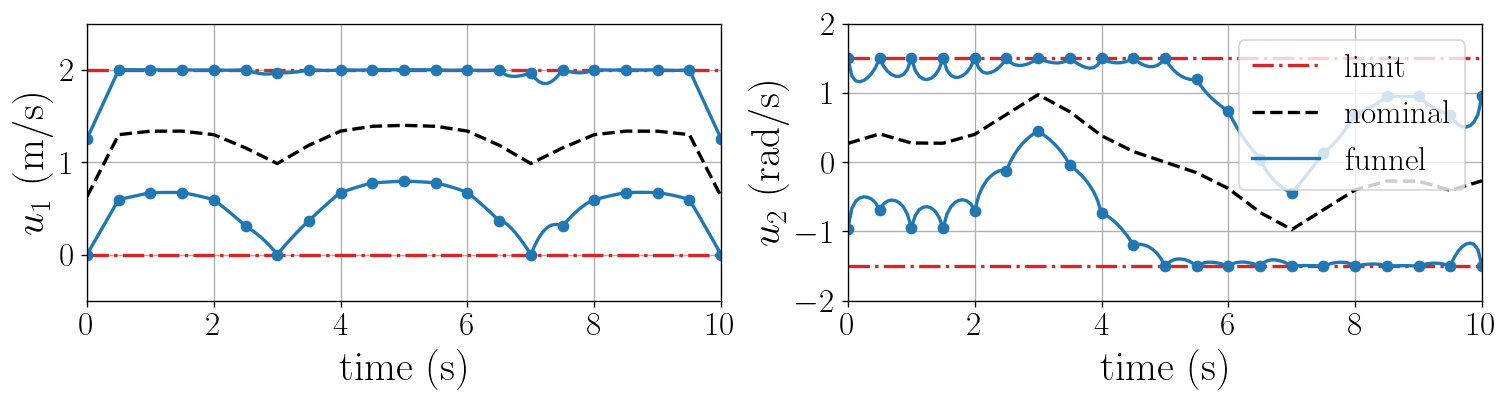

In [87]:
plt.figure(1,figsize=(15,3))
plt.subplot(121)
ax = plt.gca()

ax.plot(tfwd, ufwd[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
ax.plot(tfwd, ufwd[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
ax.plot(tfwd, ufwd[:,0],'--',color='black',alpha=1.0,linewidth=2.0,label='nominal')

ax.plot(tfwd, ufwd[:,0]+vfunl1,'-',color='tab:blue',alpha=1.0,linewidth=2.0)
ax.plot(tfwd, ufwd[:,0]-vfunl1,'-',color='tab:blue',alpha=1.0,linewidth=2.0)
ax.plot(tnom, unom[:,0]+vfunl1_n,'o',color='tab:blue',alpha=1.0,linewidth=2.0)
ax.plot(tnom, unom[:,0]-vfunl1_n,'o',color='tab:blue',alpha=1.0,linewidth=2.0)

plt.xlabel('time (s)', fontsize = 25)
plt.ylabel('$u_1$ (m/s)', fontsize = 25)
plt.xticks(fontsize=20)
plt.yticks([-2.0,-1.0,0.0,1.0,2.0],fontsize=20)
ax.axis([0.0, tf, -0.5, 2.5])
ax.grid(True)

plt.subplot(122)
ax = plt.gca()
ax.plot(tfwd, ufwd[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
ax.plot(tfwd, ufwd[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
ax.plot(tfwd, ufwd[:,1],'--',color='black',alpha=1.0,linewidth=2.0,label='nominal')

ax.plot(tfwd, ufwd[:,1]+wfunl1,'-',color='tab:blue',alpha=1.0,linewidth=2.0,label='funnel')
ax.plot(tfwd, ufwd[:,1]-wfunl1,'-',color='tab:blue',alpha=1.0,linewidth=2.0)
ax.plot(tnom, unom[:,1]+wfunl1_n,'o',color='tab:blue',alpha=1.0,linewidth=2.0)
ax.plot(tnom, unom[:,1]-wfunl1_n,'o',color='tab:blue',alpha=1.0,linewidth=2.0)

plt.xlabel('time (s)', fontsize = 25)
plt.ylabel('$u_2$ (rad/s)', fontsize = 25)
plt.xticks(fontsize=20)
plt.yticks([-2.0,-1.0,0.0,1.0,2.0],fontsize=20)
plt.axis([0.0, tf, -2.0, 2.0])
plt.legend(fontsize=20,loc=1)
plt.grid(True)
plt.savefig('../image/input_result.pdf',bbox_inches='tight')
# plt.savefig(filepath + 'traj_result_2D.pdf',bbox_inches='tight',pad_inches=0.5)

# generate samples

In [30]:
import scipy

In [67]:
x0_sample = []
num_sample = 200
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xnom[0] + scipy.linalg.sqrtm(Q1[0])@z
    x0_sample.append(x_s)
# tsam,xsam,usam,wsam,xsamp = get_sample_trajectory(xi,x0_sample,xbar,ubar,Qbar,Ybar,myModel,N,ix,iu,iw,delT,
#                                             flag_noise=True)

In [68]:
# ufwd,Qfwd,Yfwd
def dfdt_with_nominal(t,X,w) :
    Q = Qfoh(t)
    Y = Yfoh(t)
    K = Y@np.linalg.inv(Q)
    
    xnom = X[:ix]
    xnew = X[ix:]
    unom = ufoh(t)
    unew = unom + K@(xnew-xnom)

    fnom = np.squeeze(myModel.forward(xnom,unom))
    fnew = np.squeeze(myModel.forward_uncertain(xnew,unew,w))
    return np.hstack((fnom,fnew))
list_xsam = []
list_sv = []
for x_s in x0_sample :
    X0 = np.zeros(2*ix)
    X0[:ix] = xi
    X0[ix:] = x_s

    z = np.random.randn(iw)
    w = z / np.linalg.norm(z)

    sol = solve_ivp(dfdt_with_nominal,(0,tf),X0,args=(w,),
                    t_eval=tfwd,rtol=1e-6,atol=1e-10)

    xsam = sol.y.T[:,ix:]
    eta = xsam - xfwd
    sv_sam = np.transpose(eta[:,:,np.newaxis],(0,2,1))@Qfwd_inv@eta[:,:,np.newaxis]
    list_sv.append(np.squeeze(sv_sam))
    list_xsam.append(xsam)

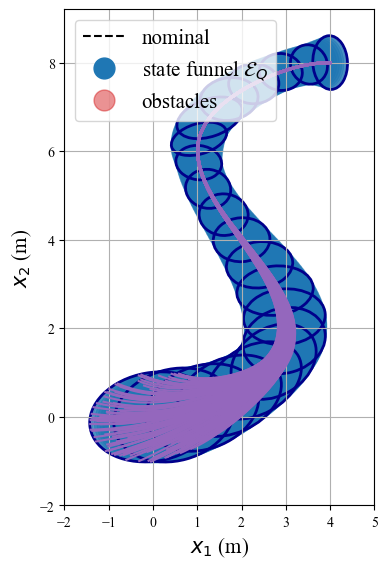

In [69]:
plt.figure(figsize=(4,8))
plot_one_funnel(xfwd,Qfwd,xnom,Q1,xi=xnom[0],xf=xnom[-1],Qi=None,Qf=None,plt=plt)
for xsam in list_xsam :
    plt.plot(xsam[:,0],xsam[:,1],'-',color='tab:purple')
plt.grid(True)

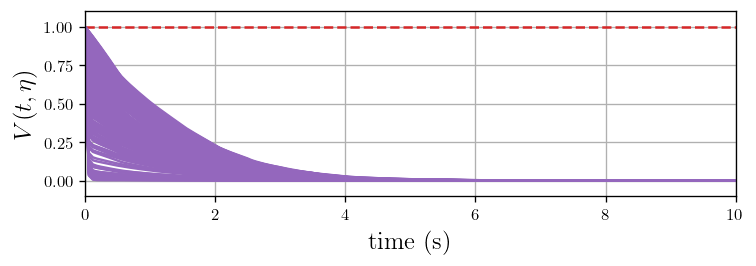

In [89]:

plt.figure(1,figsize=(7,2))
plt.plot(tfwd,0*tfwd+1,'--',color='tab:red',label='$1$')
for sv_sam in list_sv :
    plt.plot(tfwd,sv_sam,'-',color='tab:purple')
plt.grid(True)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel(r'$V(t,\eta)$', fontsize = fS)
plt.plot(1e3,1e3,'-',color='tab:purple',label='samples')
plt.axis([-0.0,10,-0.1,1.1])
# ax.legend(fontsize=15)
# ax.set_yticks([0,1,2,3,4,5,6,7,8])
plt.savefig('../image/invariance_result.pdf',bbox_inches='tight')

# plot together for paper

In [ ]:
# fig, axd = plt.subplot_mosaic([['upper left', 'upper right'],
#                                ['lower', 'lower']],figsize=(8,5),layout="constrained")
# # plt.rcParams["font.family"] = "Times New Roman"
# ax = axd['upper left']

# ax.plot(tnom, unom[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
# ax.plot(tnom, unom[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
# ax.plot(tnom, unom[:,0],'--',color='black',alpha=1.0,linewidth=2.0,label='nominal')

# ax.plot(tfwd, ufwd[:,0]+vfunl2,'-',color='tab:blue',alpha=1.0,linewidth=2.0)
# ax.plot(tfwd, ufwd[:,0]-vfunl2,'-',color='tab:blue',alpha=1.0,linewidth=2.0)

# ax.set_xlabel('time (s)', fontsize = fS)
# ax.set_ylabel('$u_v$ (m/s)', fontsize = fS)
# # ax.set_xticks(fontsize=15)
# # ax.set_yticks(fontsize=15)
# ax.axis([0.0, tf, -0.5, 2.5])
# ax.grid(True)

# ax = axd['upper right']
# ax.plot(tnom, unom[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
# ax.plot(tnom, unom[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
# ax.plot(tnom, unom[:,1],'--',color='black',alpha=1.0,linewidth=2.0,label='nominal')

# ax.plot(tfwd, ufwd[:,1]+wfunl2,'-',color='tab:blue',alpha=1.0,linewidth=2.0,label='funnel')
# ax.plot(tfwd, ufwd[:,1]-wfunl2,'-',color='tab:blue',alpha=1.0,linewidth=2.0)

# ax.set_xlabel('time (s)', fontsize = fS)
# ax.set_ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
# # plt.xticks(fontsize=15)
# # plt.yticks(fontsize=15)
# ax.axis([0.0, tf, -3, 3])
# ax.legend(fontsize=fS,loc=1)

# ax.grid(True)

# ax = axd['lower']

# ax.plot(tfwd,1/svfwd,label='$1/c(t)$')
# ax.plot(tfwd,exponential_decay,'--',color='tab:orange',label='$e^{-{ \\alpha}(t-t_0)}/c(t_0)$')
# plt.plot(tfwd,0*tfwd+1,'--',color='tab:red',label='$1$')
# for sv_sam in list_sv :
#     ax.plot(tfwd,sv_sam,'-',color='tab:purple')
# ax.grid(True)
# ax.set_xlabel('time (s)', fontsize = fS)
# ax.set_ylabel(r'$(x-\bar{x})^{\top} Q^{-1} (x-\bar{x})$', fontsize = fS)
# ax.plot(1e3,1e3,'-',color='tab:purple',label='samples')
# ax.axis([-0.2,5.2,-0.5,12])
# ax.legend(fontsize=15)
# # ax.set_yticks([0,1,2,3,4,5,6,7,8])
# # plt.yticks(range(0,13))
    
    
# # plt.tight_layout()


In [ ]:
# plt.figure(figsize=(7,7))
# plot_two_funnel(xnom,Q2,S2,xi=xnom[0],xf=xnom[-1],Qi=Qini,Qf=Qf,plt=plt)
# plt.grid(True)

# ax = plt.gca()
# for ce,H in zip(c_list,H_list) :
#     rx = 1/H[0,0]
#     ry = 1/H[1,1]
#     circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=0.5,fill=True)
#     ax.add_patch(circle1)
# plt.grid(True)
